In [73]:
import numpy as np
import jax.numpy as jnp
from matplotlib import pyplot as plt
from pylab import figure, cm
import random
from jax import grad, jit, hessian
from timeit import default_timer as timer
from IPython.display import clear_output
from multiprocessing import Pool
from functools import partial

m=1.0
omega = 1.0
lam = 5
hbar = 1.0
R = .2
# number of parameters in the ansatz
num_params = 4
# number of coordinates in the ansatz
num_coords = 2

def psi(coords, params):
    return params[0] * jnp.exp(-.5 *(coords[0]**2 + coords[1]**2))*(params[1]+params[2]*(coords[0] - coords[1]) + params[3]*(coords[0] - coords[1])**2)

def logpsi(coords, params):
    return jnp.log(psi(coords, params))

def dpsi(coords, params, i):
    return jacobian(psi)(coords, params)[i]

def ddpsi(coords, params, i):
    fcoords = [float(val) for val in coords]
    h = jit(hessian(psi))
    return h(fcoords, params)[i][i]
#print(ddpsi([.1,.1], [.5,.5,.5,.5], 0))
partials = jit(grad(logpsi, argnums=1))


def V(coords):
    return .5 * omega**2 * (coords[0]**2 + coords[1] ** 2) + lam * np.exp(-((coords[0] - coords[1])/R)**2)

def Hpsi(coords, params):
    hpsi = V(coords) * psi(coords, params)
    for i in range(num_coords):
        hpsi += -hbar**2/(2*m)*ddpsi(coords, params, i)
    return hpsi

def sample(params, num_samples):
    outputs = []
    coords_t = [0 for i in range(num_coords)]
    for _ in range(num_samples):
        coords_prime = [0 for i in range(num_coords)]
        for i in range(num_coords):
            coords_prime[i] = coords_t[i] + random.uniform(-1,1)
        if (random.uniform(0,1) < psi(coords_prime, params)**2/psi(coords_t,params)**2):
            coords_t = coords_prime
        outputs.append(coords_t)
    return outputs

def grad_log_psi(coords, params):
    # this will return a vector of length len(params)
    grad = np.zeros(len(params))
    # now add in the derivatives with respect to each variable
    for i in range(num_params):
        grad[i] = partials(coords, params)[i]
    return grad

def avg_energy(params, N=10**3):
    # get N sampled points
    samples = sample(params, N)
    # apply the function to every point
    applied = [(1/psi(coords, params) * Hpsi(coords, params)) for coords in samples]
    return 1/N * sum(applied)

def gradient(params, N):
    samples = sample(params, N)
    # first compute all used values to decrease recomputation

    # with Pool(5) as pool:
    #     gradlogs = pool.map(partial(grad_log_psi, params=params), samples)
    #     psi_neg = pool.map(partial(1/psi, params=params), samples)
    #     hpsis = pool.map(partial(Hpsi, params=params), samples)
    gradlogs = [grad_log_psi(coords, params) for coords in samples]
    psi_neg = [1/psi(coords, params) for coords in samples]
    hpsis = [Hpsi(coords, params) for coords in samples]
    psi_neg_times_hpsis = [(psi_neg[i] * hpsis[i]) for i in range(len(samples))]
    # now compute the 3 different averages
    energy_exp = 1/N * sum([psi_neg_times_hpsis[i] for i in range(len(samples))])
    print("Average Energy: " + str(energy_exp))
    gradlogpsi_exp = 1/N * sum(gradlogs, 0)
    both_exp = 1/N * sum([(psi_neg_times_hpsis[i] * gradlogs[i]) for i in range(len(samples))], 0)
    return (2 * both_exp - 2 * energy_exp * gradlogpsi_exp)

def grad_opt(start_params, learning_rate=.1, max_iterations=100, tolerance=.001, N=10**2):
    # pick the starting position
    params = start_params
    hist = []
    # iterate until we run out of iterations or less than tolerance
    for it in range(max_iterations):
        clear_output(wait=True)
        # compute the gradient at that point
        diff = np.asarray((learning_rate * gradient(params, N)))
        if all((abs(val) < tolerance) for val in diff):
            print("All under tolerance")
            return hist
        # make a step in the direction opposite the gradient
        params = params - diff
        # print(params)
        hist.append(params)
    return hist

In [74]:
start = [.5, 1.0, .5, 0.0]

hist = grad_opt(start)
optd = hist[-1]

2022-07-14 16:30:55.992854: F external/org_tensorflow/tensorflow/stream_executor/cuda/cuda_driver.cc:146] Failed setting context: CUDA_ERROR_NOT_INITIALIZED: initialization error
2022-07-14 16:30:55.993484: F external/org_tensorflow/tensorflow/stream_executor/cuda/cuda_driver.cc:146] Failed setting context: CUDA_ERROR_NOT_INITIALIZED: initialization error
2022-07-14 16:30:56.000542: F external/org_tensorflow/tensorflow/stream_executor/cuda/cuda_driver.cc:146] Failed setting context: CUDA_ERROR_NOT_INITIALIZED: initialization error
2022-07-14 16:30:56.002729: F external/org_tensorflow/tensorflow/stream_executor/cuda/cuda_driver.cc:146] Failed setting context: CUDA_ERROR_NOT_INITIALIZED: initialization error
2022-07-14 16:30:56.017419: F external/org_tensorflow/tensorflow/stream_executor/cuda/cuda_driver.cc:146] Failed setting context: CUDA_ERROR_NOT_INITIALIZED: initialization error
2022-07-14 16:30:56.065306: F external/org_tensorflow/tensorflow/stream_executor/cuda/cuda_driver.cc:146]

KeyboardInterrupt: 

In [54]:
# get a contour plot of the wavefunction
size = 100
xmin = -5
xmax = 5
ymin = -5
ymax = 5

X = np.linspace(xmin, xmax, size)
Y = np.linspace(ymin, ymax, size)
Z = [[psi([i, j], optd) for i in X] for j in Y]

[ 0.50000057  1.11948454 -0.02876013  0.36829413]


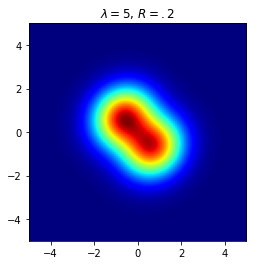

In [57]:
print(optd)
plt.title(r"$\lambda = 5$, $R = .2$")
plt.imshow(Z,extent=[xmin, xmax, ymin, ymax], cmap=cm.jet, origin='lower')
#plt.contour(X,Y,Z)
plt.show()

In [4]:
# plotting the value of lambda  vs the minimized energy
lambdas = np.linspace(.1, 10, 10)
energies = []
ps = []
for l in lambdas:
    lam = l
    start = [.5, .5, .5, .5]
    hist = grad_opt(start)
    optd = hist[-1]
    ps.append(optd)
    energies.append(avg_energy(optd))


Average Energy: 1.8780218
Average Energy: 1.8241894
Average Energy: 1.2985965
Average Energy: 1.5238035
Average Energy: 1.4632081
Average Energy: 1.3985548
Average Energy: 1.3647403
Average Energy: 1.2412308
Average Energy: 1.0620393
Average Energy: 1.1020654
Average Energy: 0.8297987
Average Energy: 1.3347361
Average Energy: 1.1447695
Average Energy: 1.0555695
Average Energy: 1.0684315
Average Energy: 1.0361897
Average Energy: 1.0186107
Average Energy: 1.0193489
Average Energy: 1.0793791
Average Energy: 1.0463604
Average Energy: 1.0378518
Average Energy: 1.0552992
Average Energy: 1.0530585
Average Energy: 1.1024975
Average Energy: 1.0277038
Average Energy: 1.0541068
Average Energy: 1.0567654
Average Energy: 1.057459
Average Energy: 1.0578704
Average Energy: 1.0610397
Average Energy: 1.0594736
Average Energy: 1.0586603
Average Energy: 1.0582047
Average Energy: 1.0556618
Average Energy: 1.0547155
All under tolerance
Average Energy: 2.3165984
Average Energy: 1.8523744
Average Energy: 1.7

In [1]:
plt.scatter(lambdas, energies)
plt.title(r"$\lambda$ vs Average Energy")
plt.show()


NameError: name 'plt' is not defined